In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_ch_32_DO_BN(conv_num=1):
    model=Sequential()

    model.add(Conv1D (kernel_size=5, filters=32, strides=1, 
                      padding='same', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=32*(2**int((i+1)/4)), 
                          strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))
        
    model.add(Flatten())
    model.add(Dropout(0.75))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(3, 10):
    model = build_1d_cnn_custom_ch_32_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 32)         128       
_________________________________________________________________
activation (Activation)      (None, 16000, 32)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 16000, 32)         128       
_________________________________________________________________
activation_1 (Activat

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_12 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_12 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_13 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_13 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 5333, 32)          0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_33 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_33 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_33 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_34 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_34 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 5333, 32)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.9764 - acc: 0.2288
Epoch 00001: val_loss improved from inf to 1.93603, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_BN_3_conv_checkpoint/001-1.9360.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 2.9766 - acc: 0.2288 - val_loss: 1.9360 - val_acc: 0.3841
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0970 - acc: 0.3770
Epoch 00002: val_loss improved from 1.93603 to 1.61369, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_BN_3_conv_checkpoint/002-1.6137.hdf5
36805/36805 [==============================] - 41s 1ms/sample - loss: 2.0971 - acc: 0.3770 - val_loss: 1.6137 - val_acc: 0.5017
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8014 - acc: 0.4538
Epoch 00003: val_loss improved from 1.61369 to 1.52

36800/36805 [============================>.] - ETA: 0s - loss: 0.6318 - acc: 0.7950
Epoch 00025: val_loss did not improve from 1.22079
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.6319 - acc: 0.7950 - val_loss: 1.2649 - val_acc: 0.6362
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6077 - acc: 0.7991
Epoch 00026: val_loss did not improve from 1.22079
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.6076 - acc: 0.7991 - val_loss: 1.3353 - val_acc: 0.6205
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5963 - acc: 0.8028
Epoch 00027: val_loss did not improve from 1.22079
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.5965 - acc: 0.8027 - val_loss: 1.2312 - val_acc: 0.6513
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5922 - acc: 0.8029
Epoch 00028: val_loss improved from 1.22079 to 1.19459, saving model to model/checkpoint

36800/36805 [============================>.] - ETA: 0s - loss: 0.3726 - acc: 0.8750
Epoch 00053: val_loss did not improve from 1.13903
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.3726 - acc: 0.8750 - val_loss: 1.2756 - val_acc: 0.6599
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3633 - acc: 0.8790
Epoch 00054: val_loss did not improve from 1.13903
36805/36805 [==============================] - 40s 1ms/sample - loss: 0.3635 - acc: 0.8790 - val_loss: 1.2189 - val_acc: 0.6867
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3593 - acc: 0.8804
Epoch 00055: val_loss did not improve from 1.13903
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.3593 - acc: 0.8804 - val_loss: 1.1992 - val_acc: 0.6832
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3635 - acc: 0.8790
Epoch 00056: val_loss did not improve from 1.13903
36805/36805 [========================

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2700 - acc: 0.9099
Epoch 00083: val_loss did not improve from 1.12750
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.2702 - acc: 0.9098 - val_loss: 1.2927 - val_acc: 0.6699
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2679 - acc: 0.9115
Epoch 00084: val_loss did not improve from 1.12750
36805/36805 [==============================] - 40s 1ms/sample - loss: 0.2679 - acc: 0.9115 - val_loss: 1.4827 - val_acc: 0.6571
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2710 - acc: 0.9113
Epoch 00085: val_loss did not improve from 1.12750
36805/36805 [==============================] - 40s 1ms/sample - loss: 0.2710 - acc: 0.9113 - val_loss: 1.2166 - val_acc: 0.6979
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2611 - acc: 0.9121
Epoch 00086: val_loss did not improve from 1.12750
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.2160 - acc: 0.9295
Epoch 00112: val_loss did not improve from 1.10373
36805/36805 [==============================] - 40s 1ms/sample - loss: 0.2160 - acc: 0.9295 - val_loss: 1.1512 - val_acc: 0.7386
Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2161 - acc: 0.9279
Epoch 00113: val_loss did not improve from 1.10373
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.2161 - acc: 0.9279 - val_loss: 1.3951 - val_acc: 0.6928
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2186 - acc: 0.9286
Epoch 00114: val_loss did not improve from 1.10373
36805/36805 [==============================] - 40s 1ms/sample - loss: 0.2186 - acc: 0.9286 - val_loss: 1.2511 - val_acc: 0.7140
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2127 - acc: 0.9296
Epoch 00115: val_loss did not improve from 1.10373
36805/36805 [=====================

Epoch 142/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1896 - acc: 0.9383
Epoch 00142: val_loss did not improve from 1.10373
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.1897 - acc: 0.9383 - val_loss: 1.3544 - val_acc: 0.6990
Epoch 143/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1890 - acc: 0.9376
Epoch 00143: val_loss did not improve from 1.10373
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.1889 - acc: 0.9376 - val_loss: 2.0796 - val_acc: 0.5518

1D_CNN_custom_ch_32_DO_075_DO_BN_3_conv Model


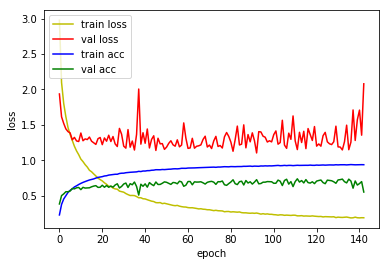

4815/4815 [==============================] - 2s 453us/sample - loss: 1.2868 - acc: 0.6816
Loss: 1.2867762950102983 Accuracy: 0.68161994

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.3409 - acc: 0.1861
Epoch 00001: val_loss improved from inf to 2.01857, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_BN_4_conv_checkpoint/001-2.0186.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 3.3410 - acc: 0.1860 - val_loss: 2.0186 - val_acc: 0.3750
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2216 - acc: 0.3574
Epoch 00002: val_loss improved from 2.01857 to 1.54680, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_BN_4_conv_checkpoint/002-1.5468.hdf5
36805/36805 [==============================] - 42s 1ms/sample - loss: 2.2216 - acc: 0.3575 - val_loss: 1.5468 - val_acc: 0.5255
Epoch 3/500
36800/36805 [============================>.] -

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7471 - acc: 0.7690
Epoch 00024: val_loss did not improve from 0.78375
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.7471 - acc: 0.7691 - val_loss: 0.8355 - val_acc: 0.7503
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7336 - acc: 0.7724
Epoch 00025: val_loss did not improve from 0.78375
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.7336 - acc: 0.7724 - val_loss: 0.9001 - val_acc: 0.7352
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7206 - acc: 0.7794
Epoch 00026: val_loss did not improve from 0.78375
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.7206 - acc: 0.7794 - val_loss: 0.8231 - val_acc: 0.7617
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6981 - acc: 0.7830
Epoch 00027: val_loss did not improve from 0.78375
36805/36805 [===========

Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5197 - acc: 0.8363
Epoch 00052: val_loss did not improve from 0.69735
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.5198 - acc: 0.8362 - val_loss: 0.7413 - val_acc: 0.7932
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5155 - acc: 0.8388
Epoch 00053: val_loss did not improve from 0.69735
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.5157 - acc: 0.8387 - val_loss: 0.7284 - val_acc: 0.7906
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5106 - acc: 0.8377
Epoch 00054: val_loss did not improve from 0.69735
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.5106 - acc: 0.8377 - val_loss: 0.7505 - val_acc: 0.7887
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5059 - acc: 0.8397
Epoch 00055: val_loss improved from 0.69735 to 0.69205, saving model to mod

Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4179 - acc: 0.8661
Epoch 00081: val_loss did not improve from 0.67830
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.4179 - acc: 0.8661 - val_loss: 0.7193 - val_acc: 0.8057
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4122 - acc: 0.8682
Epoch 00082: val_loss did not improve from 0.67830
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.4122 - acc: 0.8683 - val_loss: 0.6795 - val_acc: 0.8204
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4101 - acc: 0.8680
Epoch 00083: val_loss did not improve from 0.67830
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.4101 - acc: 0.8680 - val_loss: 0.6800 - val_acc: 0.8199
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4083 - acc: 0.8689
Epoch 00084: val_loss did not improve from 0.67830
36805/36805 [===========

Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3584 - acc: 0.8831
Epoch 00110: val_loss did not improve from 0.67418
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.3585 - acc: 0.8830 - val_loss: 0.7433 - val_acc: 0.8013
Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3482 - acc: 0.8876
Epoch 00111: val_loss did not improve from 0.67418
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.3482 - acc: 0.8875 - val_loss: 0.7032 - val_acc: 0.8106
Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3525 - acc: 0.8858
Epoch 00112: val_loss did not improve from 0.67418
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.3525 - acc: 0.8859 - val_loss: 0.7606 - val_acc: 0.7985
Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3457 - acc: 0.8896
Epoch 00113: val_loss did not improve from 0.67418
36805/36805 [=======

36800/36805 [============================>.] - ETA: 0s - loss: 0.3193 - acc: 0.8948
Epoch 00139: val_loss did not improve from 0.65987
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.3193 - acc: 0.8948 - val_loss: 0.7373 - val_acc: 0.8095
Epoch 140/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3147 - acc: 0.8971
Epoch 00140: val_loss did not improve from 0.65987
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.3150 - acc: 0.8971 - val_loss: 0.7344 - val_acc: 0.8125
Epoch 141/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3112 - acc: 0.8994
Epoch 00141: val_loss did not improve from 0.65987
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.3111 - acc: 0.8994 - val_loss: 0.7052 - val_acc: 0.8195
Epoch 142/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3147 - acc: 0.8982
Epoch 00142: val_loss did not improve from 0.65987
36805/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.2888 - acc: 0.9045
Epoch 00168: val_loss did not improve from 0.65785
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.2889 - acc: 0.9045 - val_loss: 0.6829 - val_acc: 0.8281
Epoch 169/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2858 - acc: 0.9064
Epoch 00169: val_loss did not improve from 0.65785
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.2858 - acc: 0.9064 - val_loss: 0.6971 - val_acc: 0.8246
Epoch 170/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2866 - acc: 0.9076
Epoch 00170: val_loss did not improve from 0.65785
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.2866 - acc: 0.9076 - val_loss: 0.6928 - val_acc: 0.8283
Epoch 171/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2883 - acc: 0.9055
Epoch 00171: val_loss did not improve from 0.65785
36805/36805 [=====================

Epoch 198/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2674 - acc: 0.9121
Epoch 00198: val_loss did not improve from 0.65785
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.2674 - acc: 0.9121 - val_loss: 0.6898 - val_acc: 0.8316
Epoch 199/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2692 - acc: 0.9105
Epoch 00199: val_loss did not improve from 0.65785
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.2693 - acc: 0.9104 - val_loss: 0.7101 - val_acc: 0.8223
Epoch 200/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2681 - acc: 0.9129
Epoch 00200: val_loss did not improve from 0.65785
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.2681 - acc: 0.9129 - val_loss: 0.8052 - val_acc: 0.7985
Epoch 201/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2647 - acc: 0.9137
Epoch 00201: val_loss did not improve from 0.65785
36805/36805 [=======

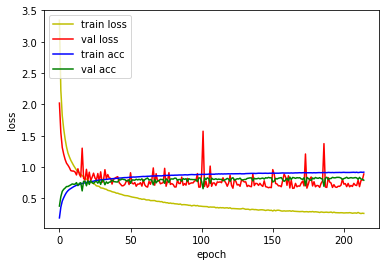

4815/4815 [==============================] - 2s 472us/sample - loss: 0.7213 - acc: 0.8019
Loss: 0.721279725231238 Accuracy: 0.80186915

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.2662 - acc: 0.1808
Epoch 00001: val_loss improved from inf to 1.91855, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_BN_5_conv_checkpoint/001-1.9186.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 3.2663 - acc: 0.1808 - val_loss: 1.9186 - val_acc: 0.3666
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1347 - acc: 0.3697
Epoch 00002: val_loss improved from 1.91855 to 1.38745, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_BN_5_conv_checkpoint/002-1.3875.hdf5
36805/36805 [==============================] - 44s 1ms/sample - loss: 2.1346 - acc: 0.3697 - val_loss: 1.3875 - val_acc: 0.5756
Epoch 3/500
36800/36805 [============================>.] - 

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6371 - acc: 0.8070
Epoch 00025: val_loss improved from 0.61092 to 0.60792, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_BN_5_conv_checkpoint/025-0.6079.hdf5
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.6372 - acc: 0.8070 - val_loss: 0.6079 - val_acc: 0.8309
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6291 - acc: 0.8083
Epoch 00026: val_loss did not improve from 0.60792
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.6291 - acc: 0.8083 - val_loss: 0.8976 - val_acc: 0.7405
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6187 - acc: 0.8112
Epoch 00027: val_loss did not improve from 0.60792
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.6190 - acc: 0.8112 - val_loss: 0.7101 - val_acc: 0.7966
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4496 - acc: 0.8604
Epoch 00053: val_loss did not improve from 0.56794
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.4496 - acc: 0.8604 - val_loss: 0.7728 - val_acc: 0.7862
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4503 - acc: 0.8600
Epoch 00054: val_loss improved from 0.56794 to 0.56761, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_BN_5_conv_checkpoint/054-0.5676.hdf5
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.4503 - acc: 0.8600 - val_loss: 0.5676 - val_acc: 0.8486
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4426 - acc: 0.8616
Epoch 00055: val_loss improved from 0.56761 to 0.54141, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_BN_5_conv_checkpoint/055-0.5414.hdf5
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.4426 - acc: 0.8616

36800/36805 [============================>.] - ETA: 0s - loss: 0.3691 - acc: 0.8841
Epoch 00080: val_loss did not improve from 0.51384
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.3692 - acc: 0.8840 - val_loss: 0.5340 - val_acc: 0.8535
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3656 - acc: 0.8833
Epoch 00081: val_loss did not improve from 0.51384
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.3657 - acc: 0.8833 - val_loss: 0.5332 - val_acc: 0.8577
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3573 - acc: 0.8871
Epoch 00082: val_loss did not improve from 0.51384
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.3573 - acc: 0.8872 - val_loss: 0.5527 - val_acc: 0.8479
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3640 - acc: 0.8847
Epoch 00083: val_loss did not improve from 0.51384
36805/36805 [========================

36800/36805 [============================>.] - ETA: 0s - loss: 0.3134 - acc: 0.9003
Epoch 00109: val_loss did not improve from 0.50019
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.3134 - acc: 0.9003 - val_loss: 0.5250 - val_acc: 0.8661
Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3156 - acc: 0.8980
Epoch 00110: val_loss did not improve from 0.50019
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.3156 - acc: 0.8979 - val_loss: 0.5348 - val_acc: 0.8609
Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3100 - acc: 0.8998
Epoch 00111: val_loss did not improve from 0.50019
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.3103 - acc: 0.8997 - val_loss: 0.5459 - val_acc: 0.8481
Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3083 - acc: 0.9036
Epoch 00112: val_loss did not improve from 0.50019
36805/36805 [=====================

Epoch 139/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2736 - acc: 0.9112
Epoch 00139: val_loss improved from 0.50019 to 0.49684, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_BN_5_conv_checkpoint/139-0.4968.hdf5
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.2737 - acc: 0.9112 - val_loss: 0.4968 - val_acc: 0.8737
Epoch 140/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2745 - acc: 0.9101
Epoch 00140: val_loss did not improve from 0.49684
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.2745 - acc: 0.9101 - val_loss: 0.5004 - val_acc: 0.8728
Epoch 141/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2679 - acc: 0.9129
Epoch 00141: val_loss did not improve from 0.49684
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.2680 - acc: 0.9129 - val_loss: 0.5526 - val_acc: 0.8577
Epoch 142/500
36800/36805 [============================>.] - ETA

36800/36805 [============================>.] - ETA: 0s - loss: 0.2464 - acc: 0.9200
Epoch 00168: val_loss did not improve from 0.49684
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.2464 - acc: 0.9200 - val_loss: 0.5087 - val_acc: 0.8684
Epoch 169/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2450 - acc: 0.9200
Epoch 00169: val_loss did not improve from 0.49684
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.2450 - acc: 0.9200 - val_loss: 0.5205 - val_acc: 0.8726
Epoch 170/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2439 - acc: 0.9218
Epoch 00170: val_loss did not improve from 0.49684
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.2439 - acc: 0.9218 - val_loss: 0.7284 - val_acc: 0.8099
Epoch 171/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2456 - acc: 0.9195
Epoch 00171: val_loss did not improve from 0.49684
36805/36805 [=====================

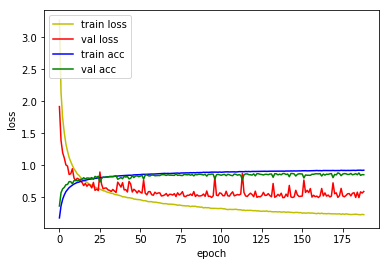

4815/4815 [==============================] - 2s 507us/sample - loss: 0.5648 - acc: 0.8461
Loss: 0.5647518580947709 Accuracy: 0.84610593

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.3059 - acc: 0.1417
Epoch 00001: val_loss improved from inf to 2.13847, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_BN_6_conv_checkpoint/001-2.1385.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 3.3059 - acc: 0.1417 - val_loss: 2.1385 - val_acc: 0.3068
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2627 - acc: 0.3120
Epoch 00002: val_loss improved from 2.13847 to 1.56266, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_BN_6_conv_checkpoint/002-1.5627.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 2.2627 - acc: 0.3120 - val_loss: 1.5627 - val_acc: 0.5208
Epoch 3/500
36800/36805 [============================>.] -

36800/36805 [============================>.] - ETA: 0s - loss: 0.6032 - acc: 0.8204
Epoch 00023: val_loss did not improve from 0.52003
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.6034 - acc: 0.8204 - val_loss: 0.5291 - val_acc: 0.8516
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5837 - acc: 0.8267
Epoch 00024: val_loss did not improve from 0.52003
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.5836 - acc: 0.8267 - val_loss: 0.5496 - val_acc: 0.8437
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5714 - acc: 0.8320
Epoch 00025: val_loss did not improve from 0.52003
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.5715 - acc: 0.8320 - val_loss: 0.5378 - val_acc: 0.8521
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5695 - acc: 0.8301
Epoch 00026: val_loss did not improve from 0.52003
36805/36805 [========================

Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4185 - acc: 0.8721
Epoch 00049: val_loss did not improve from 0.39385
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.4185 - acc: 0.8721 - val_loss: 0.4005 - val_acc: 0.8915
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4170 - acc: 0.8738
Epoch 00050: val_loss did not improve from 0.39385
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.4170 - acc: 0.8738 - val_loss: 0.4379 - val_acc: 0.8840
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4113 - acc: 0.8761
Epoch 00051: val_loss improved from 0.39385 to 0.37718, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_BN_6_conv_checkpoint/051-0.3772.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.4113 - acc: 0.8761 - val_loss: 0.3772 - val_acc: 0.8945
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s

36800/36805 [============================>.] - ETA: 0s - loss: 0.3425 - acc: 0.8951
Epoch 00077: val_loss did not improve from 0.34694
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.3426 - acc: 0.8951 - val_loss: 0.3529 - val_acc: 0.9078
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3315 - acc: 0.8984
Epoch 00078: val_loss did not improve from 0.34694
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.3319 - acc: 0.8983 - val_loss: 0.3720 - val_acc: 0.9008
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3329 - acc: 0.8970
Epoch 00079: val_loss did not improve from 0.34694
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.3329 - acc: 0.8969 - val_loss: 0.3531 - val_acc: 0.9080
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3323 - acc: 0.8992
Epoch 00080: val_loss improved from 0.34694 to 0.34609, saving model to model/checkpoint

Epoch 105/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2873 - acc: 0.9121
Epoch 00105: val_loss did not improve from 0.32880
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.2873 - acc: 0.9121 - val_loss: 0.3511 - val_acc: 0.9094
Epoch 106/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2874 - acc: 0.9100
Epoch 00106: val_loss did not improve from 0.32880
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.2876 - acc: 0.9100 - val_loss: 0.3452 - val_acc: 0.9110
Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2833 - acc: 0.9105
Epoch 00107: val_loss improved from 0.32880 to 0.32258, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_BN_6_conv_checkpoint/107-0.3226.hdf5
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.2833 - acc: 0.9105 - val_loss: 0.3226 - val_acc: 0.9194
Epoch 108/500
36800/36805 [============================>.] - ETA

Epoch 134/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2491 - acc: 0.9221
Epoch 00134: val_loss did not improve from 0.31148
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.2490 - acc: 0.9221 - val_loss: 0.3344 - val_acc: 0.9147
Epoch 135/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2467 - acc: 0.9230
Epoch 00135: val_loss did not improve from 0.31148
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.2466 - acc: 0.9231 - val_loss: 0.3579 - val_acc: 0.9138
Epoch 136/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2447 - acc: 0.9231
Epoch 00136: val_loss did not improve from 0.31148
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.2447 - acc: 0.9231 - val_loss: 0.3118 - val_acc: 0.9236
Epoch 137/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2438 - acc: 0.9227
Epoch 00137: val_loss did not improve from 0.31148
36805/36805 [=======

36800/36805 [============================>.] - ETA: 0s - loss: 0.2211 - acc: 0.9290
Epoch 00163: val_loss did not improve from 0.30779
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.2211 - acc: 0.9290 - val_loss: 0.3285 - val_acc: 0.9206
Epoch 164/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2198 - acc: 0.9283
Epoch 00164: val_loss did not improve from 0.30779
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.2198 - acc: 0.9283 - val_loss: 0.3326 - val_acc: 0.9147
Epoch 165/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2137 - acc: 0.9315
Epoch 00165: val_loss did not improve from 0.30779
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.2137 - acc: 0.9315 - val_loss: 0.5518 - val_acc: 0.8637
Epoch 166/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2204 - acc: 0.9291
Epoch 00166: val_loss did not improve from 0.30779
36805/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.2010 - acc: 0.9336
Epoch 00192: val_loss did not improve from 0.30010
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.2011 - acc: 0.9336 - val_loss: 0.3396 - val_acc: 0.9189
Epoch 193/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1957 - acc: 0.9371
Epoch 00193: val_loss did not improve from 0.30010
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1958 - acc: 0.9370 - val_loss: 0.3080 - val_acc: 0.9229
Epoch 194/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1945 - acc: 0.9362
Epoch 00194: val_loss did not improve from 0.30010
36805/36805 [==============================] - 45s 1ms/sample - loss: 0.1945 - acc: 0.9362 - val_loss: 0.3306 - val_acc: 0.9196
Epoch 195/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1962 - acc: 0.9355
Epoch 00195: val_loss did not improve from 0.30010
36805/36805 [=====================

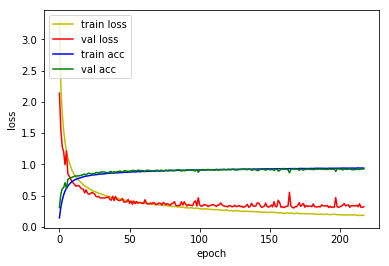

4815/4815 [==============================] - 3s 543us/sample - loss: 0.3728 - acc: 0.8951
Loss: 0.3728217562503904 Accuracy: 0.8951194

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.5703 - acc: 0.1176
Epoch 00001: val_loss improved from inf to 2.28887, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_BN_7_conv_checkpoint/001-2.2889.hdf5
36805/36805 [==============================] - 57s 2ms/sample - loss: 3.5702 - acc: 0.1176 - val_loss: 2.2889 - val_acc: 0.2891
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5144 - acc: 0.2410
Epoch 00002: val_loss improved from 2.28887 to 1.70528, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_BN_7_conv_checkpoint/002-1.7053.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 2.5144 - acc: 0.2409 - val_loss: 1.7053 - val_acc: 0.5010
Epoch 3/500
36800/36805 [============================>.] - 

36800/36805 [============================>.] - ETA: 0s - loss: 0.5153 - acc: 0.8435
Epoch 00023: val_loss improved from 0.39712 to 0.38254, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_BN_7_conv_checkpoint/023-0.3825.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.5153 - acc: 0.8435 - val_loss: 0.3825 - val_acc: 0.8945
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5030 - acc: 0.8483
Epoch 00024: val_loss did not improve from 0.38254
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.5031 - acc: 0.8483 - val_loss: 0.4048 - val_acc: 0.8908
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4904 - acc: 0.8532
Epoch 00025: val_loss improved from 0.38254 to 0.35423, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_BN_7_conv_checkpoint/025-0.3542.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.4904 - acc: 0.8532 - val_loss: 

Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3161 - acc: 0.9015
Epoch 00049: val_loss did not improve from 0.26108
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.3162 - acc: 0.9015 - val_loss: 0.2889 - val_acc: 0.9236
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3148 - acc: 0.9031
Epoch 00050: val_loss did not improve from 0.26108
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.3148 - acc: 0.9031 - val_loss: 0.2927 - val_acc: 0.9187
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3078 - acc: 0.9047
Epoch 00051: val_loss did not improve from 0.26108
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.3078 - acc: 0.9047 - val_loss: 0.2791 - val_acc: 0.9276
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3062 - acc: 0.9031
Epoch 00052: val_loss did not improve from 0.26108
36805/36805 [===========

Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2433 - acc: 0.9226
Epoch 00078: val_loss did not improve from 0.22585
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.2434 - acc: 0.9226 - val_loss: 0.2444 - val_acc: 0.9387
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2377 - acc: 0.9262
Epoch 00079: val_loss did not improve from 0.22585
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.2377 - acc: 0.9262 - val_loss: 0.2401 - val_acc: 0.9324
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2318 - acc: 0.9275
Epoch 00080: val_loss did not improve from 0.22585
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.2318 - acc: 0.9275 - val_loss: 0.2350 - val_acc: 0.9357
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2347 - acc: 0.9249
Epoch 00081: val_loss did not improve from 0.22585
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.1914 - acc: 0.9377
Epoch 00107: val_loss did not improve from 0.22054
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1914 - acc: 0.9378 - val_loss: 0.2324 - val_acc: 0.9404
Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1914 - acc: 0.9383
Epoch 00108: val_loss did not improve from 0.22054
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1914 - acc: 0.9383 - val_loss: 0.2409 - val_acc: 0.9387
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1880 - acc: 0.9397
Epoch 00109: val_loss did not improve from 0.22054
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1881 - acc: 0.9397 - val_loss: 0.2674 - val_acc: 0.9338
Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1927 - acc: 0.9374
Epoch 00110: val_loss did not improve from 0.22054
36805/36805 [=====================

Epoch 137/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1618 - acc: 0.9486
Epoch 00137: val_loss did not improve from 0.22054
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1618 - acc: 0.9486 - val_loss: 0.2526 - val_acc: 0.9387
Epoch 138/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1562 - acc: 0.9485
Epoch 00138: val_loss did not improve from 0.22054
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1562 - acc: 0.9485 - val_loss: 0.2569 - val_acc: 0.9378
Epoch 139/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1617 - acc: 0.9471
Epoch 00139: val_loss did not improve from 0.22054
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.1617 - acc: 0.9471 - val_loss: 0.2357 - val_acc: 0.9453
Epoch 140/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1585 - acc: 0.9496
Epoch 00140: val_loss did not improve from 0.22054
36805/36805 [=======

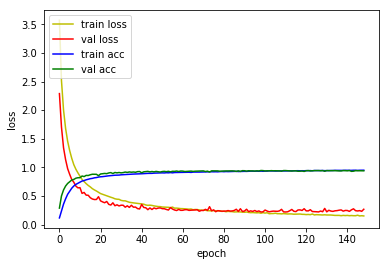

4815/4815 [==============================] - 3s 574us/sample - loss: 0.2614 - acc: 0.9252
Loss: 0.26139286952102914 Accuracy: 0.92523366

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.4718 - acc: 0.1192
Epoch 00001: val_loss improved from inf to 2.32432, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_BN_8_conv_checkpoint/001-2.3243.hdf5
36805/36805 [==============================] - 62s 2ms/sample - loss: 3.4718 - acc: 0.1192 - val_loss: 2.3243 - val_acc: 0.2732
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5439 - acc: 0.2101
Epoch 00002: val_loss improved from 2.32432 to 1.86477, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_BN_8_conv_checkpoint/002-1.8648.hdf5
36805/36805 [==============================] - 47s 1ms/sample - loss: 2.5439 - acc: 0.2101 - val_loss: 1.8648 - val_acc: 0.4510
Epoch 3/500
36800/36805 [============================>.] 

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4026 - acc: 0.8794
Epoch 00023: val_loss improved from 0.26588 to 0.23978, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_BN_8_conv_checkpoint/023-0.2398.hdf5
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.4027 - acc: 0.8794 - val_loss: 0.2398 - val_acc: 0.9383
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3899 - acc: 0.8818
Epoch 00024: val_loss improved from 0.23978 to 0.23678, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_BN_8_conv_checkpoint/024-0.2368.hdf5
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.3900 - acc: 0.8818 - val_loss: 0.2368 - val_acc: 0.9350
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3813 - acc: 0.8841
Epoch 00025: val_loss did not improve from 0.23678
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.3814 - acc: 0.8841

Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2376 - acc: 0.9263
Epoch 00049: val_loss did not improve from 0.17668
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.2378 - acc: 0.9263 - val_loss: 0.1794 - val_acc: 0.9525
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2281 - acc: 0.9276
Epoch 00050: val_loss did not improve from 0.17668
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.2281 - acc: 0.9276 - val_loss: 0.1786 - val_acc: 0.9495
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2242 - acc: 0.9313
Epoch 00051: val_loss did not improve from 0.17668
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.2243 - acc: 0.9313 - val_loss: 0.2162 - val_acc: 0.9401
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2207 - acc: 0.9319
Epoch 00052: val_loss did not improve from 0.17668
36805/36805 [===========

Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1556 - acc: 0.9498
Epoch 00078: val_loss did not improve from 0.15935
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.1555 - acc: 0.9498 - val_loss: 0.1718 - val_acc: 0.9515
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1573 - acc: 0.9486
Epoch 00079: val_loss did not improve from 0.15935
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.1573 - acc: 0.9486 - val_loss: 0.1962 - val_acc: 0.9471
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1581 - acc: 0.9493
Epoch 00080: val_loss did not improve from 0.15935
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.1581 - acc: 0.9493 - val_loss: 0.1770 - val_acc: 0.9555
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1535 - acc: 0.9509
Epoch 00081: val_loss did not improve from 0.15935
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.1192 - acc: 0.9620
Epoch 00107: val_loss did not improve from 0.15820
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.1192 - acc: 0.9620 - val_loss: 0.1706 - val_acc: 0.9548
Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1155 - acc: 0.9619
Epoch 00108: val_loss did not improve from 0.15820
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.1155 - acc: 0.9619 - val_loss: 0.1801 - val_acc: 0.9543
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1160 - acc: 0.9630
Epoch 00109: val_loss did not improve from 0.15820
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.1161 - acc: 0.9630 - val_loss: 0.1797 - val_acc: 0.9490
Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1195 - acc: 0.9611
Epoch 00110: val_loss did not improve from 0.15820
36805/36805 [=====================

Epoch 137/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0861 - acc: 0.9719
Epoch 00137: val_loss did not improve from 0.15820
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.0862 - acc: 0.9719 - val_loss: 0.1795 - val_acc: 0.9569
Epoch 138/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0953 - acc: 0.9684
Epoch 00138: val_loss did not improve from 0.15820
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.0955 - acc: 0.9684 - val_loss: 0.1700 - val_acc: 0.9606
Epoch 139/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0963 - acc: 0.9676
Epoch 00139: val_loss did not improve from 0.15820
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.0964 - acc: 0.9676 - val_loss: 0.1983 - val_acc: 0.9543
Epoch 140/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0910 - acc: 0.9713
Epoch 00140: val_loss did not improve from 0.15820
36805/36805 [=======

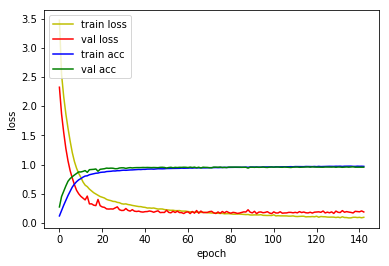

4815/4815 [==============================] - 3s 670us/sample - loss: 0.1825 - acc: 0.9458
Loss: 0.18254458988752692 Accuracy: 0.9457944

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 3.3686 - acc: 0.1536
Epoch 00001: val_loss improved from inf to 2.20298, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_BN_9_conv_checkpoint/001-2.2030.hdf5
36805/36805 [==============================] - 67s 2ms/sample - loss: 3.3686 - acc: 0.1536 - val_loss: 2.2030 - val_acc: 0.3296
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2539 - acc: 0.3159
Epoch 00002: val_loss improved from 2.20298 to 1.36932, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_BN_9_conv_checkpoint/002-1.3693.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 2.2540 - acc: 0.3159 - val_loss: 1.3693 - val_acc: 0.5966
Epoch 3/500
36800/36805 [============================>.] -

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2361 - acc: 0.9286
Epoch 00024: val_loss did not improve from 0.17008
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2361 - acc: 0.9286 - val_loss: 0.1850 - val_acc: 0.9434
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2336 - acc: 0.9283
Epoch 00025: val_loss improved from 0.17008 to 0.16563, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_BN_9_conv_checkpoint/025-0.1656.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2337 - acc: 0.9282 - val_loss: 0.1656 - val_acc: 0.9462
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2221 - acc: 0.9325
Epoch 00026: val_loss improved from 0.16563 to 0.15103, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_BN_9_conv_checkpoint/026-0.1510.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2221 - acc: 0.9325

Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1108 - acc: 0.9649
Epoch 00052: val_loss did not improve from 0.14110
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.1111 - acc: 0.9648 - val_loss: 0.1476 - val_acc: 0.9576
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1097 - acc: 0.9668
Epoch 00053: val_loss improved from 0.14110 to 0.13466, saving model to model/checkpoint/1D_CNN_custom_ch_32_DO_075_DO_BN_9_conv_checkpoint/053-0.1347.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.1097 - acc: 0.9668 - val_loss: 0.1347 - val_acc: 0.9618
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0987 - acc: 0.9689
Epoch 00054: val_loss did not improve from 0.13466
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0987 - acc: 0.9689 - val_loss: 0.1774 - val_acc: 0.9515
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s

Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0591 - acc: 0.9819
Epoch 00081: val_loss did not improve from 0.13309
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0592 - acc: 0.9819 - val_loss: 0.1658 - val_acc: 0.9609
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0686 - acc: 0.9774
Epoch 00082: val_loss did not improve from 0.13309
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0686 - acc: 0.9774 - val_loss: 0.1503 - val_acc: 0.9613
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0575 - acc: 0.9817
Epoch 00083: val_loss did not improve from 0.13309
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0576 - acc: 0.9817 - val_loss: 0.1807 - val_acc: 0.9497
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0670 - acc: 0.9792
Epoch 00084: val_loss did not improve from 0.13309
36805/36805 [===========

Epoch 111/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0414 - acc: 0.9876
Epoch 00111: val_loss did not improve from 0.13309
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0413 - acc: 0.9876 - val_loss: 0.1549 - val_acc: 0.9616
Epoch 112/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0365 - acc: 0.9890
Epoch 00112: val_loss did not improve from 0.13309
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0365 - acc: 0.9891 - val_loss: 0.1786 - val_acc: 0.9618
Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0403 - acc: 0.9877
Epoch 00113: val_loss did not improve from 0.13309
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0403 - acc: 0.9877 - val_loss: 0.1751 - val_acc: 0.9592
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0406 - acc: 0.9868
Epoch 00114: val_loss did not improve from 0.13309
36805/36805 [=======

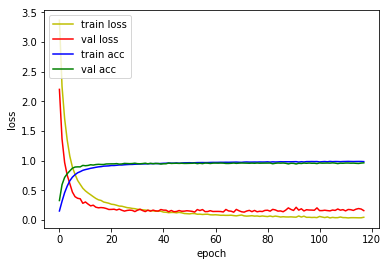

4815/4815 [==============================] - 3s 689us/sample - loss: 0.1838 - acc: 0.9491
Loss: 0.18378769090459107 Accuracy: 0.94911736



In [10]:
for i in range(3, 10):
    base = '1D_CNN_custom_ch_32_DO_075_DO_BN'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_ch_32_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_ch_32_DO_075_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_ch_32_DO_075_DO_BN_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_42 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_42 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_43 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_43 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_35 (MaxPooling 

4815/4815 [==============================] - 3s 662us/sample - loss: 0.5648 - acc: 0.8461
Loss: 0.5647518580947709 Accuracy: 0.84610593

1D_CNN_custom_ch_32_DO_075_DO_BN_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_54 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_54 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_54 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_55 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_55 (Activation

4815/4815 [==============================] - 3s 702us/sample - loss: 0.2614 - acc: 0.9252
Loss: 0.26139286952102914 Accuracy: 0.92523366

1D_CNN_custom_ch_32_DO_075_DO_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_67 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_67 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_67 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_68 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_68 (Activatio

4815/4815 [==============================] - 4s 790us/sample - loss: 0.1838 - acc: 0.9491
Loss: 0.18378769090459107 Accuracy: 0.94911736


In [12]:
for i in range(3, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


1D_CNN_custom_ch_32_DO_075_DO_BN_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_42 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_42 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_43 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_43 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
max_pooling1d_35 (MaxPooling 

4815/4815 [==============================] - 4s 796us/sample - loss: 0.6775 - acc: 0.8243
Loss: 0.6774843389371474 Accuracy: 0.82429904

1D_CNN_custom_ch_32_DO_075_DO_BN_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_54 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_54 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_54 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_55 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_55 (Activation

4815/4815 [==============================] - 4s 820us/sample - loss: 0.2828 - acc: 0.9219
Loss: 0.28284206380168225 Accuracy: 0.9219107

1D_CNN_custom_ch_32_DO_075_DO_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_67 (Conv1D)           (None, 16000, 32)         192       
_________________________________________________________________
batch_normalization_v1_67 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_67 (Activation)   (None, 16000, 32)         0         
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 16000, 32)         5152      
_________________________________________________________________
batch_normalization_v1_68 (B (None, 16000, 32)         128       
_________________________________________________________________
activation_68 (Activation

4815/4815 [==============================] - 4s 878us/sample - loss: 0.2170 - acc: 0.9466
Loss: 0.21696156144939047 Accuracy: 0.9466251
